<a href="https://colab.research.google.com/github/zunairzafar/Pytorch/blob/main/Transfomers_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Coding Transformers from Scratch**
he Transformer Architecture: A Revolution in Sequence Modeling
Overview and Impact of Transformers
The Transformer architecture is a foundational deep learning model that revolutionized
sequence modeling and natural language processing (NLP).
Introduced in the landmark paper **"Attention Is All You Need" (Vaswani et al., 2017),** Transformers
replaced recurrent and convolutional sequence models with a fully attention-based mechanism.
This shift enabled models to process entire sequences in parallel, significantly improving training
efficiency, scalability, and performance on tasks such as machine translation, text generation,
speech recognition, and multimodal learning.


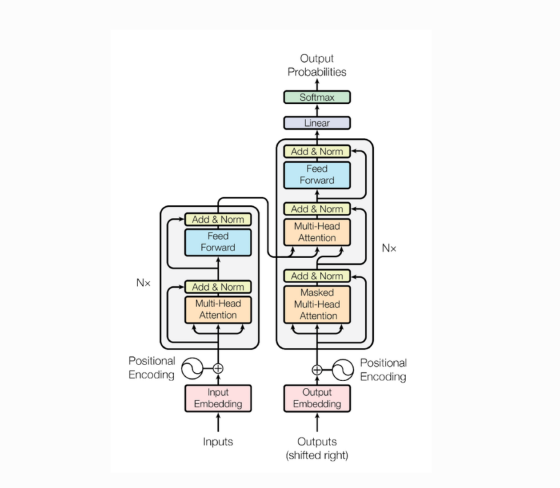

# **Workflow**
0. Import libraries and modules
1. Input Embeddings
2. Positional Encoding
3. Multi-Head Attention(Self-Attention)
4. Add&Norm(Layer Normalization)
5. Feed Forward Neural Network
6. Residual Connection
7. Encoder
8. Decoder
9. Building transformers
10. Testing
11. Tokenizer
12. Loading Dataset
13. Validation Loop
14. Training Loop
15. Conclusion

# **0. Import libraries (modules)**


In [33]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math
# HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
#-Pathlib
from pathlib import Path
#-typing
from typing import Any
#-Library for progress bars in loops
from tqdm import tqdm
#- Importing library-of-warnings
import warnings

# **1. Input Embeddings**
In the Natural Language Processing(N.L.P) domain, the computers have to play around with
the words in the language. Now, we all know that computers do not understand the words itself, rather a
bunch of numbers can do good as computers can easily understand the numbers and by manipulating
the numbers, we can play around with the words. So the scientists at that time introduced a few
techniques to represent the words as numbers. This representation is called "Vectorization". These
techniques are old and they are also utilized In the machine learning domain.
Early text representations treat language as a collection of individual words without considering their
order or meaning. In the Bag-of-Words (BoW) model, a sentence is represented by counting how many
times each word appears, while one-hot encoding represents each word as a long vector with a single
non-zero value. These methods are easy to implement, but they have important limitations. They ignore
the order of words, cannot capture similarity or meaning between words, and produce very large and
sparse representations as the vocabulary grows. As a result, they fail to model the contextual and
relational nature of language, which motivates the use of more expressive representations.
Solution to the semantic meaning capture:
This problem was solved by a technique called -> **Word embeddings** represent words as dense, lowdimensional vectors learned from data, where words with similar meanings are placed close to each
other in the vector space. Unlike one-hot encoding, embeddings capture semantic relationships between
words and provide a compact representation of language. This allows models to generalize better and
reason about meaning rather than treating words as independent symbols. However, traditional word
embeddings assign a single vector to each word, which limits their ability to represent words whose
meaning changes with context.
Each dimension in the input vector has a specific meaning or trait. In the original paper researchers used d_model = 512


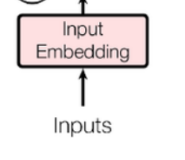


Input Seq:
> **The animal didn't cross the street because it was too tired**



*   Tokenization(dividing text)-> The, animal, didn't, cross, the ,street, because, it, was, too, tired
*   Vocabulary(Unique tokens) -> The=0, animal=1, didn't=2, cross=3, the=0, street=4, because=5, it=6, was=7, too=8, tired=9
*   Embeddings

In [34]:
class InputEmbeddings(nn.Module): #inheriting the module in Pytorch
  def __init__(self,d_model:int,vocab_size:int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.Embedding = nn.Embedding(vocab_size,d_model) # in our case its (10,512)

  def forward(self,x):
    return self.Embedding(x) * math.sqrt(self.d_model) #as mentioned in the original paper.Creates 512 dims for each input token

In [35]:
d_model = 512

# **2. Positional Encoding**

Transformers process input tokens in parallel rather than sequentially, which enables efficient computation but removes the model’s inherent awareness of token order. Unlike recurrent architectures, where sequential processing naturally encodes positional information, the parallelized batch processing in Transformers treats input tokens as an unordered set. As a result, the model cannot distinguish between different token positions solely based on the input embeddings.

To address this limitation, positional information must be explicitly injected into the model. This is achieved through positional encoding, a fundamental component of the Transformer architecture. Positional encoding provides each token with information about its position within the sequence, allowing the model to capture word order, relative distances, and sequential structure.

In practice, positional encodings are combined with token embeddings—typically through element-wise addition—before being passed to the Transformer’s input layer. These encodings can be either fixed (e.g., sinusoidal functions with varying frequencies) or learnable (trainable positional embeddings). By integrating positional encodings, Transformers are able to model sequential dependencies effectively while preserving the computational advantages of parallel processing. In this code as we are implementing the original research paper, so we are going to keep the "requires_grad=False" as they didn't trained the parameters.

$$
\mathrm{PE}(pos, 2i) = \sin\!\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

$$
\mathrm{PE}(pos, 2i+1) = \cos\!\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

where $pos$ denotes the token position in the sequence, $i$ is the dimension index, and $d_{\text{model}}$ is the model embedding dimension. Even indices of the positional encoding vector use sine functions, while odd indices use cosine functions with the same frequency. The exponential term in the denominator ensures that different dimensions correspond to sinusoidal functions with varying wavelengths, allowing the model to represent both short-range and long-range positional relationships.

The final input to the self-attention layer is obtained by adding the positional encoding to the token embeddings:

$$
X_{\text{input}} = X_{\text{embedding}} + \mathrm{PE}
$$

This additive formulation preserves the original semantic information while injecting explicit order information, enabling the self-attention mechanism to reason about relative and absolute positions. A key advantage of sinusoidal positional encodings is that they allow the model to generalize to sequence lengths longer than those seen during training, since the encodings are deterministic and not learned parameters.

In [36]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model:int, seq_len:int, dropout:float):
    super().__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    #now implement the formula step by step
    #1) We need to create a dummy matrix that's values will be filled later on.

    pe = torch.zeros(seq_len, d_model) #11 X 512 -> if seq_len = 11

    #2)Now we need to find positions
    position = torch.arange(0,seq_len, dtype= torch.float()).unsqueeze(1) #size = seq_len x 1 -> sinhle colmn matrix
    div_term = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model)) #e^log cancels each other. It is done to maintain numerical stability as said by harvard researchers. So we did the same
    pe[0,0::2] = torch.sin(position * div_term) #EVEN PE's -> as implemented in paper
    pe[0,1::2] = torch.cos(position * div_term) #ODD PE's -> as implemented in paper'
    pe = pe.unsqueeze(0) # to receive batches of data we need to add another dimension for the batches
    self.register_buffer('pe', pe ) #It will remain in state_dict but not as trainable parameters.

  def forward(self, x):
    x+= self.pe[:,:x.shape[1],:].requires_grad_(False) #addition instead of concat to reduce computational cost
    return self.dropout(x)

# **3. Multi-Head Attention**

# **i) Self-Attention**
**General-Idea**
The 2014 paper Neural Machine Translation by Jointly Learning to Align and Translate by Bahdanau, Cho, and Bengio marked a major turning point in neural sequence modeling by identifying the fixed-length context vector of early sequence-to-sequence models as a fundamental bottleneck and introducing an attention mechanism that allows the decoder to dynamically focus on different parts of the source sentence during translation, thereby jointly learning soft alignments and translation in an end-to-end differentiable manner; instead of forcing the encoder to compress all source-side information into a single vector, the model computes a context vector at each decoding step as a weighted sum of encoder hidden states, which significantly improved translation quality, especially for longer sentences. Despite its conceptual breakthrough, this approach still relied on recurrent neural networks in both the encoder and decoder, inheriting several critical limitations:
first, RNNs are inherently sequential, meaning that hidden states must be computed one time step at a time, which severely limits parallelization and makes training and inference inefficient on modern hardware;
second, although attention alleviates some information bottlenecks, long-range dependencies are still mediated through recurrent state transitions, causing gradients and information to degrade as sequence length increases, particularly for syntactic or semantic relations spanning many tokens; third, the attention mechanism in this framework is asymmetric and external, operating primarily as cross-attention from decoder to encoder, while the encoder itself still produces representations that are locally constrained by recurrence and word order. Self-attention, as later formalized in the Transformer architecture, addresses these issues in a principled and elegant way by removing recurrence entirely and allowing each token in a sequence to directly attend to every other token through learned query, key, and value projections, producing representations where dependencies between any pair of positions are modeled in a single step regardless of distance. This direct interaction enables the model to capture long-range dependencies naturally and robustly, such as coreference, agreement, and discourse-level relations, without relying on repeated state propagation

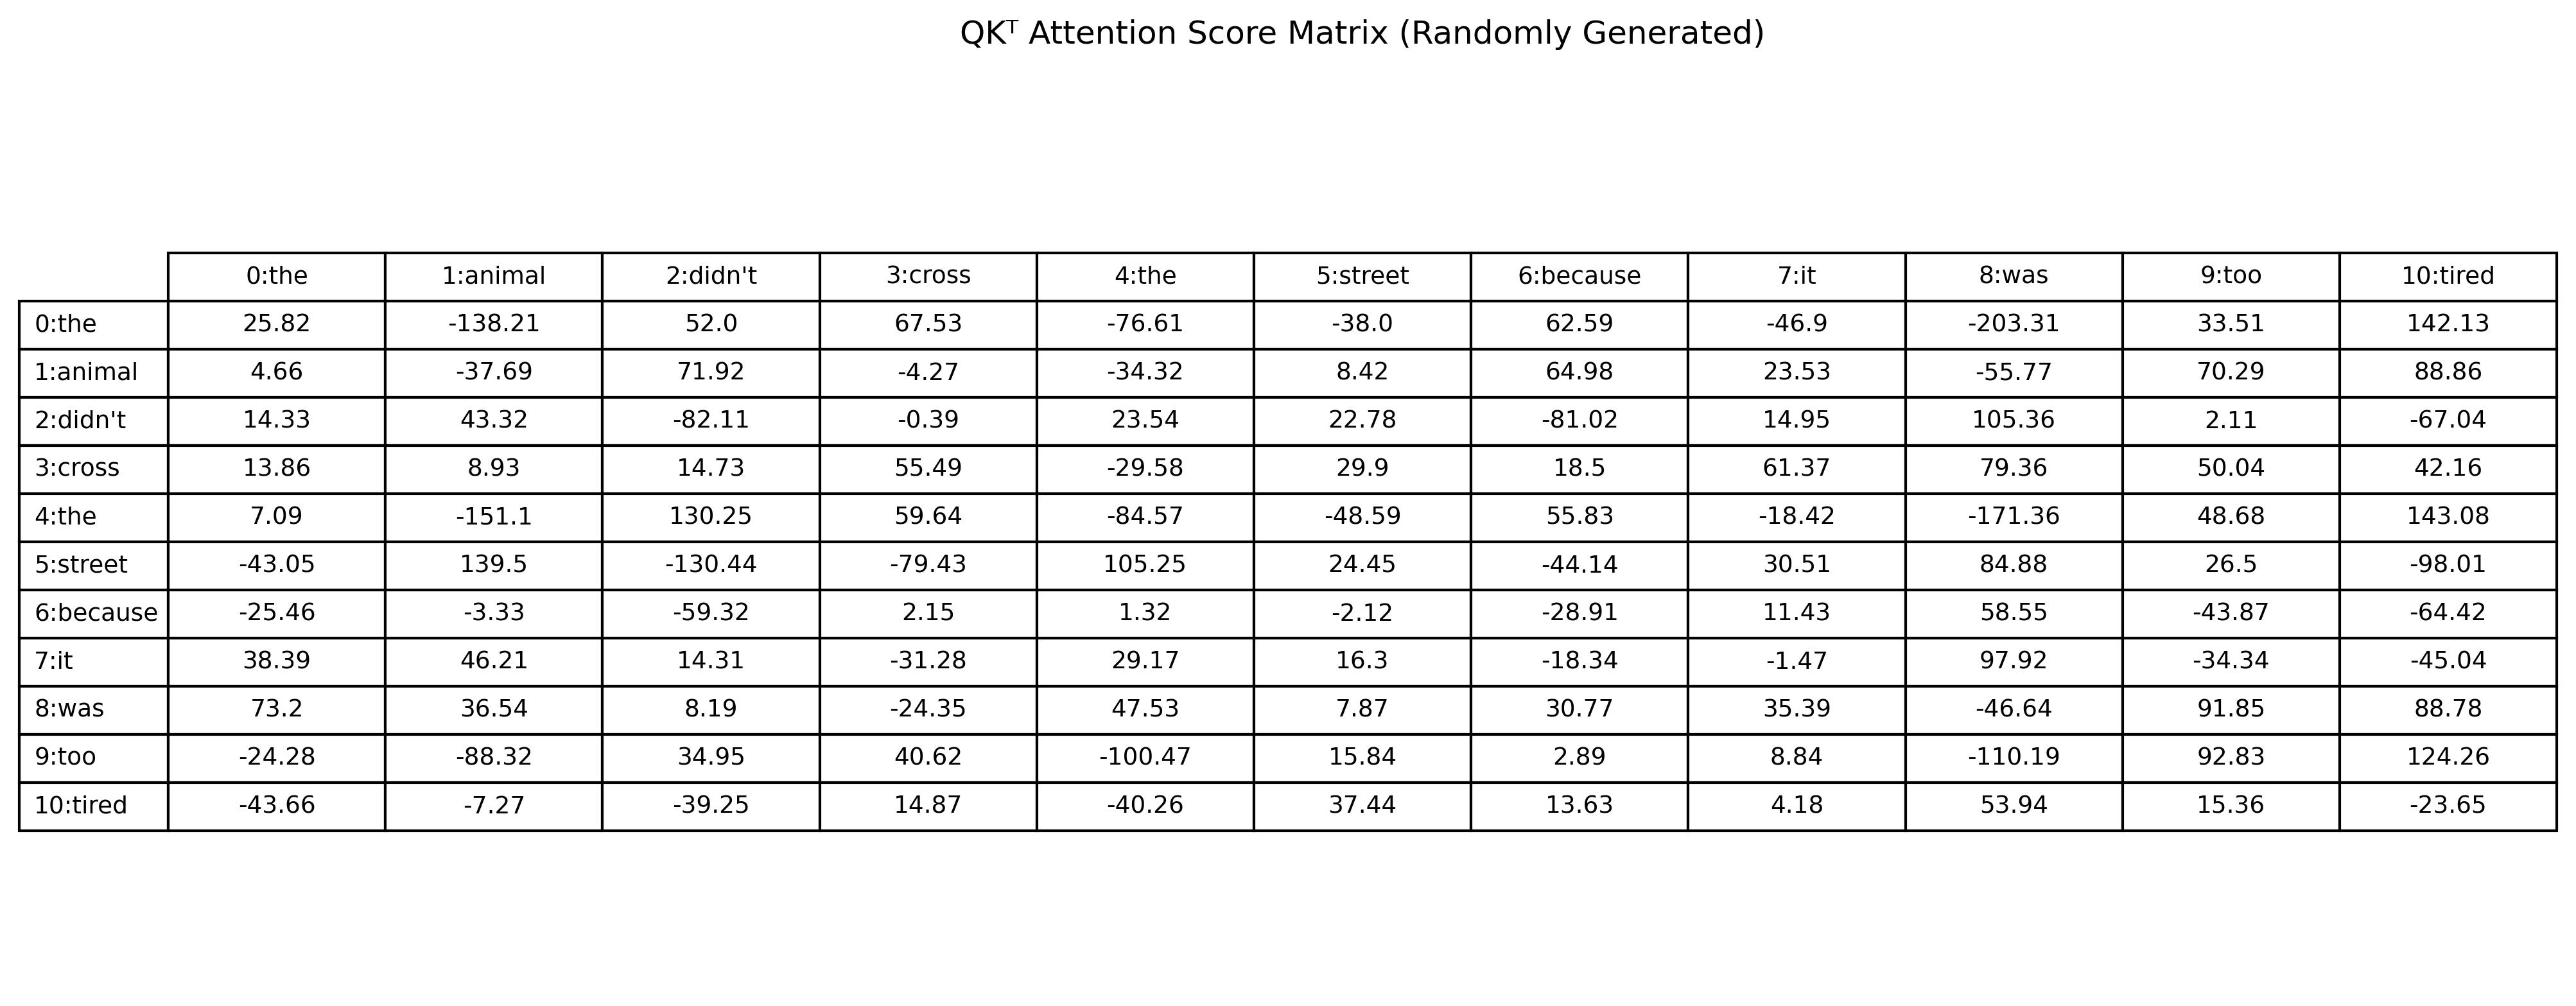

Self-attention is the mechanism that lets each token in a sequence directly interact with every other token to build contextual representations, without recurrence or convolution. Let the input sequence be embedded and stacked into a matrix $(X \in \mathbb{R}^{n \times d_{\text{model}}})$, where \(n\) is the number of tokens and \(d_{\text{model}}\) is the embedding dimension. Self-attention first produces query, key, and value matrices using learned linear projections:

$$
Q = X W_Q,\quad K = X W_K,\quad V = X W_V,
$$

where $$(W_Q, W_K, W_V \in \mathbb{R}^{d_{\text{model}} \times d_k})$$ and \(d_k\) is the query/key dimensionality. Intuitively, a query encodes what a token is looking for, a key encodes what a token offers, and a value contains the information to be aggregated. The interaction strengths are computed by dot products between queries and keys, yielding the score matrix $(QK^\top \in \mathbb{R}^{n \times n}\)$, where each entry measures how much token \(i\) should attend to token \(j\).

A critical detail is the scaling of dot-product scores before softmax. When \(d_k\) is large, dot products tend to have larger magnitude because they sum many components, which can push softmax into saturation (very peaked distributions) and cause small gradients. To stabilize training, the scores are scaled by $(1/\sqrt{d_k})$, giving the scaled dot-product attention:

$$
\mathrm{Attention}(Q,K,V) = \mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V.
$$

After applying softmax, each row becomes a probability distribution over all tokens, indicating how much information the current token should take from every position in the sequence. Multiplying this normalized attention matrix by \(V\) produces the updated token representations, each as a weighted sum of value vectors. This design captures long-range dependencies efficiently because any two tokens can interact directly in a single step, regardless of their distance. Because the computation is dominated by matrix multiplications, self-attention is also highly parallelizable on GPUs and TPUs, avoiding the sequential bottleneck of RNN-based models.


# **Scaled-Dot Product Attention**
\In self-attention, the strength of interaction between tokens is computed using the dot product between query and key vectors. For a query vector $Q_i \in \mathbb{R}^{d_k}$ and a key vector $K_j \in \mathbb{R}^{d_k}$, the attention score is defined as

$$
Q_i \cdot K_j = \sum_{m=1}^{d_k} Q_{i,m} K_{j,m}.
$$

This computation has an important statistical consequence. The dot product involves multiplying corresponding elements of two vectors and then summing the results across all $d_k$ dimensions. Even if each component $Q_{i,m}$ and $K_{j,m}$ has zero mean and moderate variance, the summation over many dimensions causes the resulting value to grow in magnitude. Since the dot product is a sum of $d_k$ random terms, its variance increases approximately linearly with $d_k$. As a result, the attention score matrix

$$
QK^\top \in \mathbb{R}^{n \times n}
$$

can have very large variance, leading to extremely large positive or negative values.

Neural networks do not behave well when internal activations become too large. High-variance activations can cause exploding gradients in some regions and vanishing gradients in others, both of which slow down or destabilize training. In self-attention, these dot-product scores are passed through a softmax function, and when the input values are large, softmax becomes saturated, producing near one-hot outputs. This saturation severely reduces gradient magnitudes, making learning inefficient or causing training to stall. Therefore, high variance in attention scores is undesirable.

To address this issue, self-attention uses a fundamental statistical property of variance under scaling. Let $X$ be a random variable with variance $\mathrm{Var}(X)$. If we define a new random variable $Y$ by scaling $X$ with a constant $c$,

$$
Y = cX,
$$

then the variance of $Y$ is given by

$$
\mathrm{Var}(Y) = c^2 \, \mathrm{Var}(X).
$$

This property allows direct control over the variance of dot-product attention scores. Since the variance of $Q_i \cdot K_j$ grows proportionally to $d_k$, scaling the dot product by $1/\sqrt{d_k}$ counteracts this growth. Using the scaling factor

$$
c = \frac{1}{\sqrt{d_k}},
$$

we obtain

$$
\mathrm{Var}\!\left(\frac{Q_i \cdot K_j}{\sqrt{d_k}}\right)
= \frac{1}{d_k} \, \mathrm{Var}(Q_i \cdot K_j).
$$

This normalization keeps the variance of attention scores in a stable range, independent of the dimensionality. Consequently, scaled dot-product attention is defined as

$$
\mathrm{Attention}(Q,K,V)
= \mathrm{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V.
$$

By applying this scaling before softmax, self-attention prevents variance explosion, avoids softmax saturation, maintains healthy gradient flow, and enables stable and efficient training even for large embedding dimensions.
**The below picture is taken from the original paper**

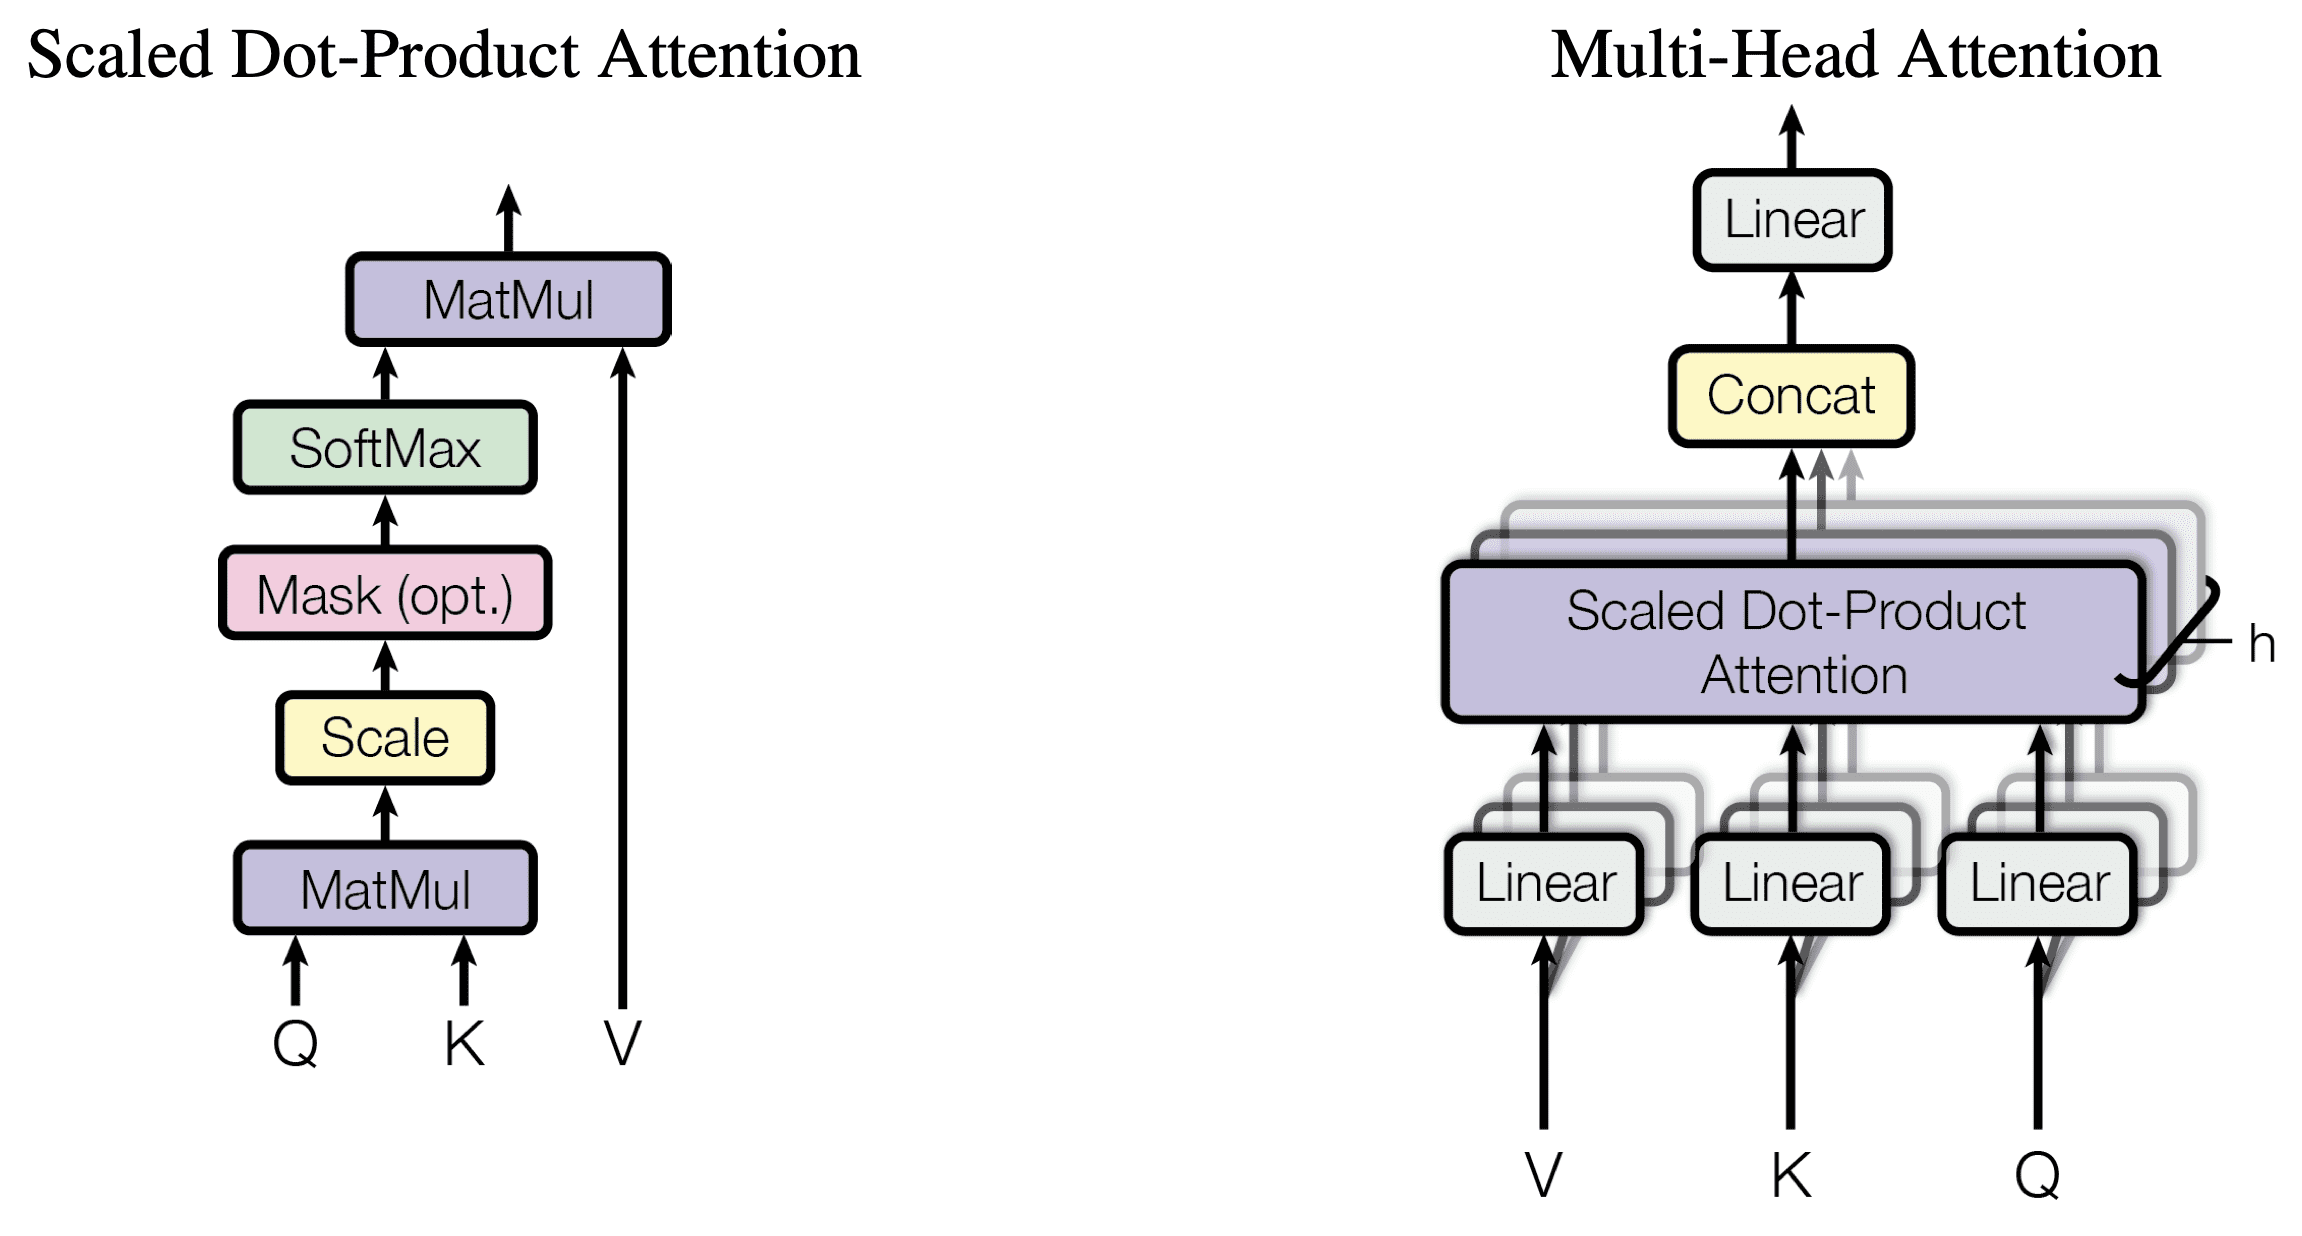

In [37]:
#________________ROUGH WORK____________________
import torch
import torch.nn as nn
import math
batch_size = 1
seq_len = 11
d_model = 512
input = torch.randn((batch_size, seq_len, d_model))
w_q = nn.Linear(d_model, d_model)
w_k = nn.Linear(d_model, d_model)
w_v = nn.Linear(d_model, d_model)
w_o = nn.Linear(d_model, d_model)

q = w_q(input)
k = w_k(input)
v = w_v(input)

#q.shape, k.shape, v.shape #shape [1,11,512]

#q, k,v is ready but we need to divide 512 to 8 heads

head = 8
d_k = d_model // head

q = q.view(q.shape[0], q.shape[1], head, d_k).transpose(1,2)
k = k.view(k.shape[0], k.shape[1], head, d_k).transpose(1,2)
v = v.view(v.shape[0], v.shape[1], head, d_k).transpose(1,2)
q.shape #torch.Size([1, 11, 8, 64])
attention_score = (q @ k.transpose(-2,-1) )/ math.sqrt(d_k)
#print(attention_score.shape) #torch.Size([1, 8, 11, 11])
attention_score = attention_score.softmax(dim=-1)
output = attention_score @ v
output.shape #torch.Size([1, 8, 11, 64])
#to concat, we have to multiply 8*64 to get 512 again
#we did this in th original class
#for concat
#output.shape torch.Size([1, 8, 11, 64])
output= output.transpose(1,2).contiguous().view(output.shape[0],-1,head*d_k)
output = w_o(output)
output.shape

torch.Size([1, 11, 512])

In [38]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model:int, head:int, dropout:float) ->None:
      super().__init__()
      self.d_model = d_model
      self.head = head
      self.d_k = d_model // head
      assert d_model%head == 0, "d_model must be divisible by head"
      self.w_q = nn.Linear(d_model, d_model) #[512,512]
      self.w_k = nn.Linear(d_model, d_model)
      self.w_v = nn.Linear(d_model, d_model)
      self.w_o = nn.Linear(d_model, d_model)
      self.dropout = nn.Dropout(dropout)
    @staticmethod
    def Attention(query, key, value, mask, dropout=nn.Dropout):
      d_k = query.shape[-1]
      attention_score = (query @ key.transpose(-2,-1) )/ math.sqrt(d_k)
      if mask is not None:
        attention_score = attention_score.masked_fill(mask==0, -1e9)
      attention_score = attention_score.softmax(dim=-1)
      if dropout is not None:
        attention_score = dropout(attention_score)
      return attention_score @ value, attention_score




    def forward(self, q, k, v, mask):
      query = self.w_q(q) #broadcastable -> torch.Size([1, 11, 512])
      key = self.w_k(k) #same for this
      value = self.w_v(v) #same for this

      #now according to the paper, the next step is to divide 512 to 3 equal parts and add 8 heads. As per paper, to allow parallelization, there will be no new tensor formation, d_model will be divided into 8 equal parts
      query = query.view(query.shape[0], query.shape[1], self.head, self.d_k).transpose(1,2)
      #now dims will be[1,8,11,64] -> means 1 batch, 8 heads, 11x64 size of seq. sme for key and vlaue

      value = value.view(value.shape[0], value.shape[1], self.head, self.d_k).transpose(1,2)
      key = key.view(key.shape[0], key.shape[1], self.head, self.d_k).transpose(1,2)
      #this will allow parallel computation now. we can send batches to the heads at the same time.
      #now create static method before this forward method and simply call it to apply attention mechanism as the dims are sorted now.
      x, self.attention_score = MultiHeadAttentionBlock.Attention(query, key, value, mask, self.dropout)
      #see rough work for better understading
      x = x.transpose(1,2).contiguous().view(output.shape[0],-1,self.head *self.d_k)
      x = self.w_o(x)
      return x


